# Download precompiled LAMMPS binary for Ubuntu

In [ ]:
!apt-get -qq update
!apt-get -qq install lammps
!apt-get -qq install openkim-models openkim-models-parameterized
!pip -qq install py3Dmol
!pip install pyscal3
!pip install log3

# Install micromamba
!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba

# Create an environment named "lmp" with LAMMPS + KIM + models
!./bin/micromamba create -y -n lmp -c conda-forge lammps kim-api openkim-models

In [ ]:
# Use the same micromamba you already installed
!./bin/micromamba install -y -n lmp -c conda-forge cmake ninja compilers git openmpi mpi4py kim-api openkim-models
!rm -rf lammps
!./bin/micromamba run -n lmp bash -lc 'set -e; git clone --depth=1 -b stable https://github.com/lammps/lammps.git && cd lammps && mkdir build && cd build && cmake ../cmake -G Ninja -D CMAKE_BUILD_TYPE=Release -D BUILD_SHARED_LIBS=on -D BUILD_MPI=off -D PKG_OPENMP=on -D PKG_PTM=on -D PKG_KIM=on -D PKG_MANYBODY=on -D CMAKE_PREFIX_PATH=$CONDA_PREFIX && ninja -j2'


In [ ]:
!./bin/micromamba run -n lmp bash -lc 'set -e; cd lammps/build && cmake ../cmake -G Ninja -D CMAKE_BUILD_TYPE=Release -D BUILD_SHARED_LIBS=on -D BUILD_MPI=off -D PKG_OPENMP=on -D PKG_PTM=on -D PKG_KIM=on -D PKG_MANYBODY=on -D CMAKE_PREFIX_PATH=$CONDA_PREFIX && ninja -j2'


In [ ]:
!pip -q install py3Dmol
!pip -q install pyscal3
!pip -q install lammps-logfile

  Preparing metadata (setup.py) ... done


# Check if lammps was installed
Expected: Large-scale Atomic/Molecular Massively Parallel Simulator - DD MMM YYYY - Update X

In [ ]:
!./lammps/build/lmp -h | head -n2 |tail -1

# Create LAMMPS script

In [ ]:
lmp_input = """
units       lj
atom_style  atomic

lattice     fcc 0.8442
region      box block 0 10 0 10 0 10
create_box  1 box
create_atoms 1 box

mass        1 1.0
velocity    all create 1.44 87287 loop geom

pair_style  lj/cut 2.5
pair_coeff  1 1 1.0 1.0 2.5

neighbor    0.3 bin
neigh_modify    delay 5

# Add dumping for visualization
dump        d all xyz 10 traj.xyz
dump_modify d sort id

fix         1 all nve
run         100
"""

with open("in.lj", "w") as f:
    f.write(lmp_input)


# Run simulation

In [ ]:
!lmp -in in.lj

# Functions

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import py3Dmol

def plot_lammps_thermo(logfile="log.lammps"):
    with open(logfile) as f:
        lines = [ln.strip() for ln in f]

    header_idx = None
    for i, ln in enumerate(lines):
        if ln.startswith('Step '):
            header_idx = i
            break

    if header_idx is None:
        raise ValueError(f"Couldn't find thermo header 'Step ...' in {logfile}")

    cols = lines[header_idx].split()
    data = []
    for ln in lines[header_idx + 1:]:
        if not ln or ln.startswith('Loop time'):
            break
        if not re.match(r'^\d', ln):
            continue

        parts = ln.split()
        if len(parts) != len(cols):
            continue
        data.append(parts)

    df = pd.DataFrame(data, columns=cols)
    df = df.apply(pd.to_numeric, errors='coerce').dropna()

    ax = df.plot(x='Step', y='Temp')
    ax.set_ylabel('Temp')
    plt.show()

    press_col = df.columns[df.columns.str.contains('Press', case=False)]
    if len(press_col):
        ax = df.plot(x='Step', y=press_col[0])
        ax.set_ylabel('Pressure')
        plt.show()

    return df

def show_xyz(xyz_path, step=0, width=640, height=480, style="sphere"):
    # Read frames
    with open(xyz_path) as f:
        data = f.read().strip().splitlines()
    frames = []
    i = 0
    while i < len(data):
        n = int(data[i]); comment = data[i+1] if i+1 < len(data) else ""
        block = "\n".join(data[i:i+2+n])
        frames.append(block)
        i += 2 + n

    step = max(0, min(step, len(frames)-1))
    xyz_block = frames[step]

    view = py3Dmol.view(width=width, height=height)
    view.addModel(xyz_block, "xyz")
    if style == "sphere":
        view.setStyle({"sphere": {}})
    else:
        view.setStyle({"stick": {}})
    view.zoomTo()
    return view

def animate_xyz_file(xyz_path, width=640, height=480, style="sphere", interval=50):
    with open(xyz_path) as f:
        xyz = f.read()

    view = py3Dmol.view(width=width, height=height)
    # Load all frames
    view.addModelsAsFrames(xyz, 'xyz')
    if style == "sphere":
        view.setStyle({'sphere': {}})
    else:
        view.setStyle({'stick': {}})
    view.zoomTo()
    view.setFrame(0)
    view.animate({'loop': 'forward', 'reps': 0, 'step': 1, 'interval': interval})
    return view

# Post processing

In [ ]:
df = plot_lammps_thermo("log.lammps")

# Visualization

In [ ]:
show_xyz("traj.xyz", step=1)

In [ ]:
animate_xyz_file('traj.xyz', interval=40)

# Melting

In [66]:
import numpy as np
import pyscal as pc
from scipy.optimize import curve_fit
import lammps_logfile
import matplotlib.pyplot as plt

%matplotlib inline

In [77]:
def check_coexistence(ptm_dump_filename, crystal_structure):
    sys = pc.System()
    sys.read_inputfile(ptm_dump_filename, format='lammps-dump')

    sys.calculate_cna()

    # Structure codes
    codes = np.array([int(getattr(at, "structure", 0) or 0) for at in sys.atoms], dtype=int)
    counts = {
        "fcc": int((codes == 1).sum()),
        "hcp": int((codes == 2).sum()),
        "bcc": int((codes == 3).sum()),
        "ico": int((codes == 4).sum()),
        "sc":  int((codes == 5).sum()),
    }
    counts["other"] = sys.natoms - sum(counts.values())
    counts["total"] = sys.natoms
    fraction_solid = counts[crystal_structure.lower()] / counts["total"]
    fraction_liquid = counts["other"] / counts["total"]

    coexistence = (
        (fraction_liquid + fraction_solid > 0.5)
        and (0.35 <= fraction_liquid <= 0.65)
        and (0.35 <= fraction_solid <= 0.65)
    )

    return fraction_solid, fraction_liquid, counts, coexistence

def check_steady_state(logfile, coex_time, last_frac=0.8):
    log = lammps_logfile.File(logfile)
    n_runs = log.get_num_partial_logs()
    time = np.array(log.get("Step", run_num=n_runs-1))
    temperature = np.array(log.get("Temp", run_num=n_runs-1))

    idx = np.where(time >= last_frac * coex_time)
    y = temperature[idx[0]]
    x = time[idx[0]] / 1000

    def f(x, A, B):
        return A*x + B

    popt, _ = curve_fit(f, x, y)
    slope, intercept = popt[0], popt[1]

    steady_state = (-1 < slope < 1)
    melting_temperature = np.average(temperature[idx[0]])
    melting_temperature_std = np.std(temperature[idx[0]])
    melting_temperature_ci = 1.96 * melting_temperature_std / np.sqrt(len(idx[0]))

    return steady_state, slope, intercept, melting_temperature, melting_temperature_ci
# ---------- 3) Plotting helper (stitches runs + slope line + coex marker) ----------
def plot_temps_with_fit(
    logfile,
    coex_time,
    run1=1, run2=2,
    start_ps=1.0,
    last_frac=0.8,
    timestep_ps=0.001,
    show=True
):
    log = lammps_logfile.File(logfile)

    # --- pull runs ---
    step1 = np.array(log.get("Step", run_num=run1))
    solT1 = np.array(log.get("c_Tsolid", run_num=run1))
    liqT1 = np.array(log.get("c_Tliquid", run_num=run1))
    temp1 = np.array(log.get("Temp", run_num=run1))

    t1 = step1 * timestep_ps  # ps

    # second run
    step2 = log.get("Step", run_num=run2)
    have_run2 = step2 is not None
    if have_run2:
        step2 = np.array(step2)
        solT2 = np.array(log.get("c_Tsolid", run_num=run2))
        liqT2 = np.array(log.get("c_Tliquid", run_num=run2))
        temp2 = np.array(log.get("Temp", run_num=run2))

        # stitch: run2 starts after run1
        offset_steps = step1[-1] + 1
        t2 = (step2 + offset_steps) * timestep_ps
        coex_x = offset_steps * timestep_ps  # vertical marker at coex start

        t_all   = np.concatenate([t1, t2])
        sol_all = np.concatenate([solT1, solT2])
        liq_all = np.concatenate([liqT1, liqT2])
        T_all   = np.concatenate([temp1, temp2])
        t0_ps   = coex_x
    else:
        t_all, sol_all, liq_all, T_all = t1, solT1, liqT1, temp1
        coex_x = t1[-1]
        t0_ps  = 0.0

    # --- slope & intercept from last run tail (so we can draw the line) ---
    steady_state, slope, intercept, melt_T, melt_ci = check_steady_state(
        logfile, coex_time, last_frac=last_frac
    )

    # tail start (absolute time) for the last run:
    # after stitching, tail of last run begins at: coex_x + last_frac * coex_time * timestep_ps
    tail_start_ps = coex_x + last_frac * coex_time * timestep_ps
    tail_end_ps   = t_all[-1]
    x_fit = np.array([tail_start_ps, tail_end_ps])
    y_fit = slope * (x_fit - t0_ps) + intercept

    # --- plot from start_ps onward ---
    mask = t_all >= start_ps
    plt.figure(figsize=(9, 5))
    plt.plot(t_all[mask], sol_all[mask], label="Tsolid")
    plt.plot(t_all[mask], liq_all[mask], label="Tliquid")
    plt.plot(t_all[mask],  T_all[mask],  label="Temp")

    # slope line over the tail
    plt.plot(x_fit, y_fit, 'k--', lw=1.5, label=f"tail fit: slope={slope:.3f} K/ps")

    # vertical line at coex start
    #plt.axvline(coex_x, color='k', linestyle=':', lw=1.2)
    #plt.text(coex_x, max(np.max(sol_all[mask]), np.max(liq_all[mask]), np.max(T_all[mask])),
    #         "Coexistence Run Starts", rotation=90, va="bottom", ha="left", fontsize='large')
    ax = plt.gca()
    ax.axvline(coex_x, color='k', linestyle=':', lw=1.2)
    ax.annotate(
    "Coexistence Run Starts",
    xy=(coex_x, 0.5), xycoords=ax.get_xaxis_transform(),
    xytext=(-6, 0), textcoords='offset points',
    rotation=90, ha='right', va='center', fontsize='large',
    bbox=dict(boxstyle='round,pad=0.2', fc='white', ec='none', alpha=0.5),
    )

    plt.xlabel("Time (ps)", size='xx-large')
    plt.ylabel("Temperature (K)", size='xx-large')
    plt.xticks(size='x-large'); plt.yticks(size='x-large')
    plt.legend()
    plt.tight_layout()
    if show:
        plt.show()

    return {
        "steady_state": steady_state,
        "slope": slope,
        "intercept": intercept,
        "melting_temperature": melt_T,
        "melting_temperature_ci": melt_ci,
        "coex_x_ps": coex_x
    }

In [146]:
inputs = {
    "crystal_structure": "fcc",         # LAMMPS lattice style: fcc, bcc, sc, diamond, etc.
    "lattice_parameter": 3.615,         # Lattice constant (Å)
    "mass": 63.546,                     # Mass of your atoms
    "cell_reps": 6,                     # Number of unit cells along y/z
    "cell_x": 12,                       # Number of unit cells along x direction
    "Tsolid": 800.0,                   # Target solid temperature (K)
    "Tliquid": 1500.0,                  # Target liquid temperature (K)
    "seed": 12345,                      # Random seed for velocity generation
    "equilibration_time": 200,        # Steps for equilibration
    "coex_time": 2000,                 # Steps for production run
    "last_frac": 0.8                    # fraction of the coexistence run to use to check for convergence
}


In [147]:
input_file = ''' #LAMMPS input file
boundary        p p p
units           metal
atom_style      atomic


#Atom definition:
lattice         {crystal_structure} {lattice_parameter}
region          box2 block 0 {cell_x} 0 {cell_reps} 0 {cell_reps}
create_box      1 box2
create_atoms    1 box
mass            1 {mass}

# Regions and groups
region          Rsolid block 0 {cell_reps} INF INF INF INF
group           Gsolid region Rsolid
region          Rliquid block {cell_reps} {cell_x} INF INF INF INF
group           Gliquid region Rliquid

#Settings
pair_style      kim EAM_Dynamo_MishinMehlPapaconstantopoulos_2001_Cu__MO_346334655118_005
pair_coeff      * * Cu
#pair_style      kim EAM_Dynamo_Mishin_Al_1999_Al__MO_000000043348_000
#pair_coeff     * * Al

neighbor        3.0 bin
neigh_modify    every 1 delay 0 check yes

compute         Tsolid Gsolid temp
compute         Tliquid Gliquid temp

timestep        0.001 # 1fs

thermo          100
thermo_style    custom step atoms enthalpy etotal pe ke temp c_Tsolid c_Tliquid press vol pxx pyy pzz pxy pxz pyz lx ly lz

# Initial structure relax
fix             relax all box/relax aniso 0.0
minimize        1e-10 1e-12 100000 1000000
unfix           relax

# Assign velocities
velocity        Gsolid create {Tsolid} {seed} dist gaussian mom yes rot yes
velocity        Gliquid create {Tliquid} {seed} dist gaussian mom yes rot yes

reset_timestep  0

# Equilibrarion
fix             nph_all all nph aniso 1.01 1.01 1.0
fix             temp_s Gsolid temp/berendsen {Tsolid} {Tsolid} 0.1
fix             temp_l Gliquid temp/berendsen {Tliquid} {Tliquid} 0.1
run             {equilibration_time} #100000

unfix           nph_all
unfix           temp_s
unfix           temp_l

reset_timestep  0

# --- PTM classification (per-atom) ---
compute     ptm all ptm/atom structures default   # or 'all' for more types

# booleans per-atom (1 if type matches)
variable    is_fcc   atom (c_ptm==1)
variable    is_hcp   atom (c_ptm==2)
variable    is_bcc   atom (c_ptm==3)
variable    is_ico   atom (c_ptm==4)
variable    is_sc    atom (c_ptm==5)
variable    is_other atom (c_ptm==0)              # treat as "liquid/disordered"

# reduce to global counts
compute     n_fcc   all reduce sum v_is_fcc
compute     n_hcp   all reduce sum v_is_hcp
compute     n_bcc   all reduce sum v_is_bcc
compute     n_ico   all reduce sum v_is_ico
compute     n_sc    all reduce sum v_is_sc
compute     n_other all reduce sum v_is_other

# fractions
variable    n_tot   equal count(all)
variable    f_solid equal (c_n_fcc+c_n_hcp+c_n_bcc+c_n_sc)/v_n_tot
variable    f_liq   equal c_n_other/v_n_tot

# put in thermo
thermo_style custom step temp c_Tsolid c_Tliquid v_f_solid v_f_liq

# Setup dumps
dump            d1 all image 1000 main.*.ppm type type view 90 90
dump            d2 all custom 1000 ptm.*.dump id type x y z vx vy vz
#dump            d3 all custom 1000 all_frames.dump id type x y z vx vy vz xu yu zu
#dump_modify     d3 sort id

fix             coex all nph aniso 1.01 1.01 1.0
run             {coex_time}
'''

with open('lmpmelt.in', 'w') as f:
  f.write(input_file.format(**inputs))
f.close()

In [148]:
input_file = ''' #LAMMPS input file
boundary        p p p
units           metal
atom_style      atomic


#Atom definition:
lattice         {crystal_structure} {lattice_parameter}
region          box2 block 0 {cell_x} 0 {cell_reps} 0 {cell_reps}
create_box      1 box2
create_atoms    1 box
mass            1 {mass}

# Regions and groups
region          Rsolid block 0 {cell_reps} INF INF INF INF
group           Gsolid region Rsolid
region          Rliquid block {cell_reps} {cell_x} INF INF INF INF
group           Gliquid region Rliquid

#Settings
pair_style      kim EAM_Dynamo_MishinMehlPapaconstantopoulos_2001_Cu__MO_346334655118_005
pair_coeff      * * Cu
#pair_style      kim EAM_Dynamo_Mishin_Al_1999_Al__MO_000000043348_000
#pair_coeff     * * Al

neighbor        3.0 bin
neigh_modify    every 1 delay 0 check yes

compute         Tsolid Gsolid temp
compute         Tliquid Gliquid temp

timestep        0.001 # 1fs

thermo          100
thermo_style    custom step atoms enthalpy etotal pe ke temp c_Tsolid c_Tliquid press vol pxx pyy pzz pxy pxz pyz lx ly lz

# Initial structure relax
fix             relax all box/relax aniso 0.0
minimize        1e-10 1e-12 100000 1000000
unfix           relax

# Assign velocities
velocity        Gsolid create {Tsolid} {seed} dist gaussian mom yes rot yes
velocity        Gliquid create {Tliquid} {seed} dist gaussian mom yes rot yes

reset_timestep  0

# Equilibration
dump            dequil all custom 1000 eq.*.dump id type x y z vx vy vz

fix             nph_all all nph aniso 1.01 1.01 1.0
fix             temp_s Gsolid temp/berendsen {Tsolid} {Tsolid} 0.1
fix             temp_l Gliquid temp/berendsen {Tliquid} {Tliquid} 0.1

run             {equilibration_time}

unfix           nph_all
unfix           temp_s
unfix           temp_l

undump          dequil

reset_timestep  0

# Setup dumps
variable        phase atom "1*ingroup(Gsolid)+2*ingroup(Gliquid)"
dump            d_im all image 1000 im.*.ppm type v_phase view 90 90
dump            d_ts all custom 1000 ts.*.dump id type x y z vx vy vz

fix             coex all nph aniso 1.01 1.01 1.0
run             {coex_time}
'''

with open('lmpmelt.in', 'w') as f:
  f.write(input_file.format(**inputs))
f.close()

In [149]:
!export OMP_NUM_THREADS=2
!./bin/micromamba run -n lmp env OMP_NUM_THREADS=2 lmp -in lmpmelt.in

LAMMPS (29 Aug 2024)
  using 2 OpenMP thread(s) per MPI task
Lattice spacing in x,y,z = 3.615 3.615 3.615
Created orthogonal box = (0 0 0) to (43.38 21.69 21.69)
  1 by 1 by 1 MPI processor grid
Created 1728 atoms
  using lattice units in orthogonal box = (0 0 0) to (43.38 21.69 21.69)
  create_atoms CPU = 0.001 seconds
936 atoms in group Gsolid
864 atoms in group Gliquid

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Your simulation uses code contributions which should be cited:
- OpenKIM Project: doi:10.1007/s11837-011-0102-6
- OpenKIM potential: https://openkim.org/cite/MO_346334655118_005#item-citation
The log file lists these citations in BibTeX format.

CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE-CITE

Generated 0 of 0 mixed pair_coeff terms from geometric mixing rule
Neighbor list info ...
  update: every = 1 steps, delay = 0 steps, check = yes
  max neighbors/atom: 2000, page size: 100000
  master list distance cutoff = 8.506786
  ghost atom 

In [134]:
# Coexistence
#dump_filename = f"ts.0.dump"
dump_filename = f"ts.{inputs['coex_time']}.dump"
fraction_solid, fraction_liquid, counts, coexistence = check_coexistence(
    dump_filename, inputs["crystal_structure"]
)

# Steady state + plot (from 1 ps)
inputs['last_frac'] = 0.7
res = plot_temps_with_fit(
    "log.lammps",
    coex_time=inputs["coex_time"],
    run1=1, run2=2,
    start_ps=1.0,
    last_frac=inputs['last_frac'],
    timestep_ps=0.001
)

successful = res["steady_state"] and coexistence
print(
    "=== Coexistence Summary ===\n"
    f"Melting temperature           : {res['melting_temperature']:.1f} ± {res['melting_temperature_ci']:.1f} K (95% CI)\n"
    f"Steady state (tail>{inputs['last_frac']:.1f} coex)  : {res['steady_state']}  (slope={res['slope']:.3f} K/ps)\n"
    f"Coexistence check             : {coexistence} (solid={fraction_solid:.3f}, liquid={fraction_liquid:.3f})\n"
    f"Successful (Steady & Coex)    : {successful}"
)



FileNotFoundError: Filename ts.2000.dump not found

In [123]:
from PIL import Image
from IPython.display import display

im = Image.open("ss.20000.ppm")
display(im)


FileNotFoundError: [Errno 2] No such file or directory: 'ss.20000.ppm'

In [124]:
# !pip -q install imageio imageio-ffmpeg pillow
import imageio, glob, re

def natural_key(s):
    return [int(t) if t.isdigit() else t for t in re.split(r'(\d+)', s)]

frames = sorted(glob.glob("ss.*.ppm"), key=natural_key)

# MP4
with imageio.get_writer("lammps.mp4", fps=10, codec="libx264") as w:
    for f in frames:
        w.append_data(imageio.v2.imread(f))

# GIF
imageio.mimsave("lammps.gif", [imageio.v2.imread(f) for f in frames], fps=10)
from IPython.display import Video, Image as ShowImage

display(Video("lammps.mp4", embed=True))   # MP4


ValueError: need at least one array to stack

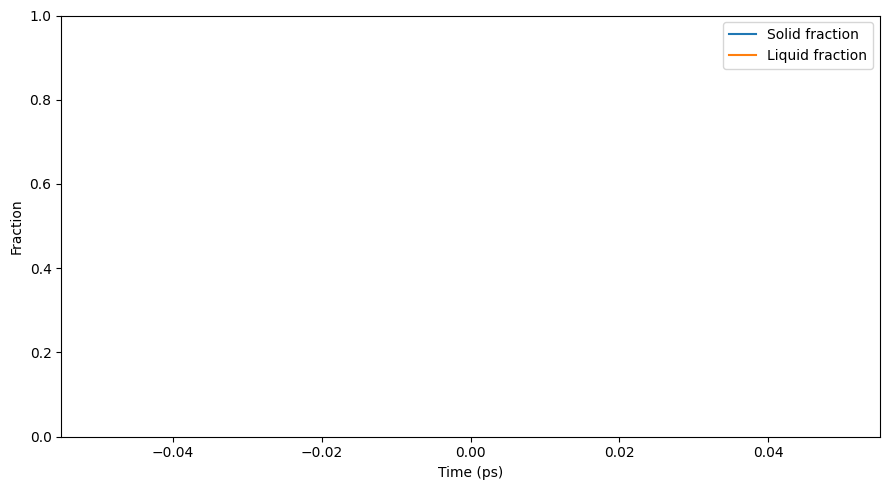

No dump files found in the requested range.


In [135]:
import os, numpy as np, matplotlib.pyplot as plt

# ---- settings ----
dump_prefix   = "equil"          # file pattern: ts.<step>.dump
start_step    = 0
end_step      = 2000
stride        = 1000          # 0, 1000, 2000, ...
timestep_ps   = 0.001         # metal units: 1 fs = 0.001 ps

# ---- gather fractions over the series ----
steps_found, times_ps = [], []
frac_solid, frac_liq, coex_flags = [], [], []

for step in range(start_step, end_step + 1, stride):
    fname = f"{dump_prefix}.{step}.dump"
    if not os.path.exists(fname):
        # silently skip missing frames
        continue

    fs, fl, counts, coex = check_coexistence(fname, inputs["crystal_structure"])
    steps_found.append(step)
    times_ps.append(step * timestep_ps)
    frac_solid.append(fs)
    frac_liq.append(fl)
    coex_flags.append(coex)

steps_found = np.array(steps_found, dtype=int)
times_ps    = np.array(times_ps, float)
frac_solid  = np.array(frac_solid, float)
frac_liq    = np.array(frac_liq, float)
coex_flags  = np.array(coex_flags, bool)

# ---- plot ----
plt.figure(figsize=(9,5))
plt.plot(times_ps, frac_solid, label="Solid fraction")
plt.plot(times_ps, frac_liq,   label="Liquid fraction")

# Optional: mark the frames that satisfied your coexistence predicate
if coex_flags.any():
    plt.scatter(times_ps[coex_flags], frac_solid[coex_flags], marker='o', s=30, label="Coex: solid pts")
    plt.scatter(times_ps[coex_flags], frac_liq[coex_flags],   marker='x', s=30, label="Coex: liquid pts")

plt.xlabel("Time (ps)")
plt.ylabel("Fraction")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# ---- quick printout of last available frame ----
if len(steps_found):
    print(f"Last frame: step={steps_found[-1]}  time={times_ps[-1]:.3f} ps")
    print(f"  solid fraction = {frac_solid[-1]:.3f}")
    print(f"  liquid fraction = {frac_liq[-1]:.3f}")
    print(f"  coexistence = {coex_flags[-1]}")
else:
    print("No dump files found in the requested range.")


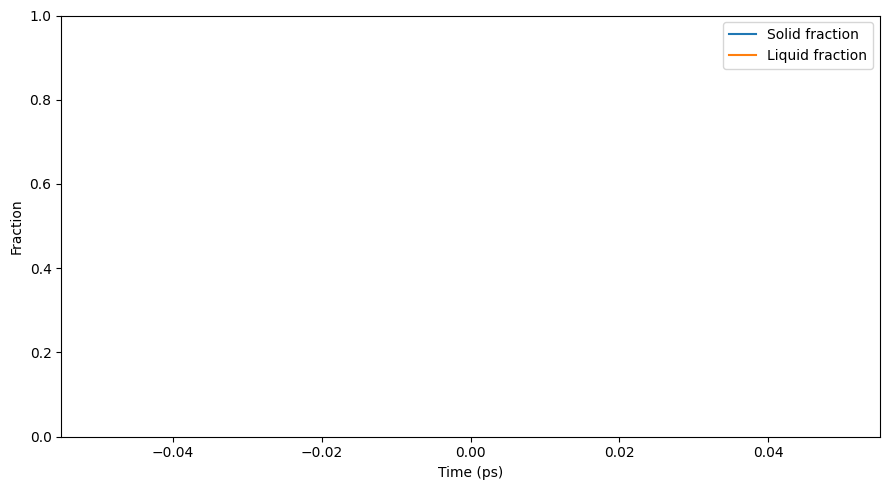

No dump files found in the requested range.


In [136]:
import os, numpy as np, matplotlib.pyplot as plt

# ---- settings ----
dump_prefix   = "ts"          # file pattern: ts.<step>.dump
start_step    = 0
end_step      = 2000
stride        = 1000          # 0, 1000, 2000, ...
timestep_ps   = 0.001         # metal units: 1 fs = 0.001 ps

# ---- gather fractions over the series ----
steps_found, times_ps = [], []
frac_solid, frac_liq, coex_flags = [], [], []

for step in range(start_step, end_step + 1, stride):
    fname = f"{dump_prefix}.{step}.dump"
    if not os.path.exists(fname):
        # silently skip missing frames
        continue

    fs, fl, counts, coex = check_coexistence(fname, inputs["crystal_structure"])
    steps_found.append(step)
    times_ps.append(step * timestep_ps)
    frac_solid.append(fs)
    frac_liq.append(fl)
    coex_flags.append(coex)

steps_found = np.array(steps_found, dtype=int)
times_ps    = np.array(times_ps, float)
frac_solid  = np.array(frac_solid, float)
frac_liq    = np.array(frac_liq, float)
coex_flags  = np.array(coex_flags, bool)

# ---- plot ----
plt.figure(figsize=(9,5))
plt.plot(times_ps, frac_solid, label="Solid fraction")
plt.plot(times_ps, frac_liq,   label="Liquid fraction")

# Optional: mark the frames that satisfied your coexistence predicate
if coex_flags.any():
    plt.scatter(times_ps[coex_flags], frac_solid[coex_flags], marker='o', s=30, label="Coex: solid pts")
    plt.scatter(times_ps[coex_flags], frac_liq[coex_flags],   marker='x', s=30, label="Coex: liquid pts")

plt.xlabel("Time (ps)")
plt.ylabel("Fraction")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# ---- quick printout of last available frame ----
if len(steps_found):
    print(f"Last frame: step={steps_found[-1]}  time={times_ps[-1]:.3f} ps")
    print(f"  solid fraction = {frac_solid[-1]:.3f}")
    print(f"  liquid fraction = {frac_liq[-1]:.3f}")
    print(f"  coexistence = {coex_flags[-1]}")
else:
    print("No dump files found in the requested range.")


In [129]:
!rm ptm.*.dump